In [56]:
# Imports for data-preprocessing
import pandas as pd
import numpy as np
from __future__ import print_function

# Import feature selection/LogR libraries
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# SVM using SVC
from sklearn.svm import SVC

# Viz libraries
import matplotlib.pyplot as plt
from string import ascii_letters
import seaborn as sns
%matplotlib inline

In [2]:
# Import data 
df = pd.read_csv('../data/master.csv')

In [3]:
df.head()

,Unnamed: 0,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_binary,condensed_education,continent,condensed_marital,condensed_workclass
0,0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,Bachelors,United States,Never,Government
1,1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,Bachelors,United States,Married,Self-Employed
2,2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,High School Graduate,United States,Divorced/Separated,Private
3,3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,No High School Diploma,United States,Married,Private
4,4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,Bachelors,Caribbean,Married,Private


In [3]:
# Delete unwanted variables
del df['workclass']
del df['education']
del df['education_num']
del df['marital_status']
del df['occupation']
del df['native_country'] 
del df['Unnamed: 0']

In [10]:
# Check df again
df.head()

,age,relationship,race,sex,capital_gain,capital_loss,hours_per_week,condensed_education,continent,condensed_marital,condensed_workclass
0,39,Not-in-family,White,Male,2174,0,40,Bachelors,United States,Never,Government
1,50,Husband,White,Male,0,0,13,Bachelors,United States,Married,Self-Employed
2,38,Not-in-family,White,Male,0,0,40,High School Graduate,United States,Divorced/Separated,Private
3,53,Husband,Black,Male,0,0,40,No High School Diploma,United States,Married,Private
4,28,Wife,Black,Female,0,0,40,Bachelors,Caribbean,Married,Private


### Training and Testing Split

The data set was split into two separte sets 

In [26]:
from sklearn.model_selection import StratifiedShuffleSplit

if 'income_binary' in df:
    y = df['income_binary'].values #get values we need 
    del df['income_binary']        #get rid of the class label
    X = df.values                  #use everything else to predict 
    
X = pd.get_dummies(df).values

# Split the data into 20% Test and 80% Train
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.20, random_state=111)
sss.get_n_splits(X, y) #retreving the splits 

10

In [27]:
print(sss)

StratifiedShuffleSplit(n_splits=10, random_state=111, test_size=0.2,
            train_size=None)


In [28]:
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [15163 16279 29246 ..., 21159 41049 17832] TEST: [43578  1917 17027 ..., 22163 39121  5217]
TRAIN: [12894 40784 33210 ..., 40386 25846 36294] TEST: [22078 13800    49 ..., 31283 31586  5940]
TRAIN: [16738 39693 30388 ...,   328 33912 39362] TEST: [24310 48705 25069 ..., 47258 14625 39292]
TRAIN: [ 7391 39777 43398 ...,  8978 24399 34458] TEST: [ 8836  1328 27156 ..., 47164 10476 15648]
TRAIN: [16863 33361 41054 ..., 26744 47828 11941] TEST: [18495 35842 20752 ..., 46535  4696 46808]
TRAIN: [ 5743 21257 30549 ...,  5927  7506 19162] TEST: [21737 30911  7484 ..., 19717 27662 19780]
TRAIN: [18797 40559 21393 ..., 47376 19268 42562] TEST: [13861 34766  4320 ..., 42723 30153 11994]
TRAIN: [36977 11147 24500 ..., 40130 15262 22626] TEST: [13974 35810 43678 ...,  7735 14376 40480]
TRAIN: [32752 37107 19197 ..., 26015 32870  7076] TEST: [36370 13966 29812 ..., 20543 23045 34324]
TRAIN: [22441 41471 48039 ..., 32784  4446 45905] TEST: [  934  1627 37667 ...,  4950 44845 21169]


In [13]:
correlation_matrix = np.corrcoef(X.T)
print(correlation_matrix)

[[ 1.          0.07722902  0.05694383 ..., -0.19126318  0.17852802
   0.02675379]
 [ 0.07722902  1.         -0.03144077 ..., -0.03698639  0.08293252
  -0.01927657]
 [ 0.05694383 -0.03144077  1.         ..., -0.0251755   0.03484551
  -0.01227187]
 ..., 
 [-0.19126318 -0.03698639 -0.0251755  ...,  1.         -0.53984939
  -0.37366187]
 [ 0.17852802  0.08293252  0.03484551 ..., -0.53984939  1.         -0.08886058]
 [ 0.02675379 -0.01927657 -0.01227187 ..., -0.37366187 -0.08886058  1.        ]]


In [14]:
def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Abalone Feature Correlation')
    labels=['age','race', 'sex', 
            'condensed_education', 'continent', 'condensed_marital', 'condensed_workclass']
    ax1.set_xticklabels(labels,fontsize=10)
    ax1.set_yticklabels(labels,fontsize=10)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[-1, -0.75, -0.50, -0.25, 0, 0.25, 0.50, .75,.8,.85,.90,.95,1])
    plt.show()

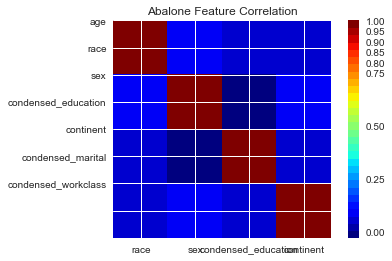

In [15]:
correlation_matrix(df)

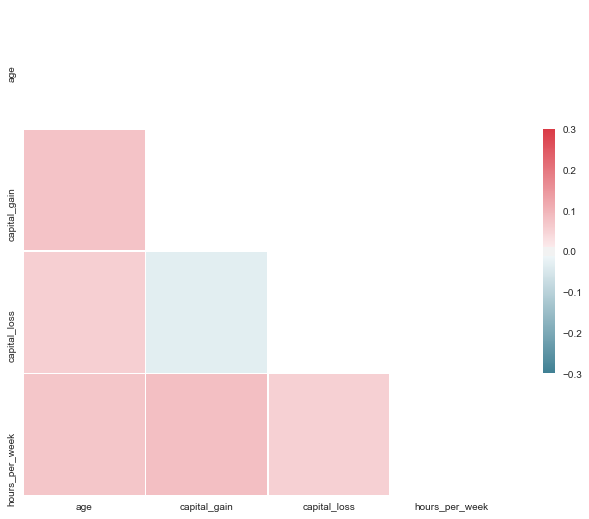

In [51]:
# Correlation between continuous variables 

sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


### Feature Selection

The goal here is to figure out how incorporating a feature selection method, recursive feature elimination, into our logistic regression models changes the prediction accuracy. The RFE selects features by recursively choosing smaller and smaller group of features. The selection starts off with the initial set of features. Then the least important features are pruned off of the current feature set. This is recursively repeated on the pruned set until it stops on the number that is chosen. Once the feature selection is complete, those chosen features will be used in the models.

In [14]:
# Feature extraction #1
# Set number of features to 3
model = LogisticRegression(penalty='l2', C=1.0)
rfe = RFE(model, 3)
fit = rfe.fit(X, y)
print("Num Features:", fit.n_features_)
print("Selected Features:", fit.support_)
print("Feature Ranking:", fit.ranking_)

Num Features: 3
Selected Features: [False False False False  True False False False False  True False False
 False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False]
Feature Ranking: [37 39 38 35  1 24 13  3 20  1 15 36 23 25 27 11 28  8 19  1  5 12  2  7 26
 16 30 17  6  4 22 18 33 21 14 10 29 34 31 32  9]


In [15]:
# Feature extraction #2
# Set number of features to 5
model2 = LogisticRegression(penalty='l2', C=1.0)
rfe2 = RFE(model2, 5)
fit2 = rfe2.fit(X, y)
print("Num Features:", fit2.n_features_)
print("Selected Features:", fit2.support_)
print("Feature Ranking:", fit2.ranking_)

Num Features: 5
Selected Features: [False False False False  True False False  True False  True False False
 False False False False False False False  True False False  True False
 False False False False False False False False False False False False
 False False False False False]
Feature Ranking: [35 37 36 33  1 22 11  1 18  1 13 34 21 23 25  9 26  6 17  1  3 10  1  5 24
 14 28 15  4  2 20 16 31 19 12  8 27 32 29 30  7]


In [16]:
# Feature extraction #3
# Set number of features to 10
model3 = LogisticRegression(penalty='l2', C=1.0)
rfe3 = RFE(model3, 10)
fit3 = rfe3.fit(X, y)
print("Num Features:", fit3.n_features_)
print("Selected Features:", fit3.support_)
print("Feature Ranking:", fit3.ranking_)

Num Features: 10
Selected Features: [False False False False  True False False  True False  True False False
 False False False False False  True False  True  True False  True  True
 False False False False  True  True False False False False False False
 False False False False False]
Feature Ranking: [30 32 31 28  1 17  6  1 13  1  8 29 16 18 20  4 21  1 12  1  1  5  1  1 19
  9 23 10  1  1 15 11 26 14  7  3 22 27 24 25  2]


### Logistic Regression

In [30]:
# RFE model #1

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(X,y): 
    X_train = X[train_indices]  # train indices for X
    y_train = y[train_indices]  # train indices for y
    
    X_test = X[test_indices]    # test indices for X
    y_test = y[test_indices]    # test indices for y
    
    # train the reusable logisitc regression model on the training data
    rfe.fit(X_train,y_train)  # train object
    y_hat_rfe = rfe.predict(X_test) # get test set precitions

    # accuracy and confusion matrix for this iterations of training/testing
    acc_rfe1 = mt.accuracy_score(y_test,y_hat_rfe)
    conf_rfe1 = mt.confusion_matrix(y_test,y_hat_rfe)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc_rfe1 )
    print("confusion matrix\n",conf_rfe1)
    iter_num+=1


====Iteration 0  ====
accuracy 0.765892107688
confusion matrix
 [[7415   16]
 [2271   67]]
====Iteration 1  ====
accuracy 0.761080970417
confusion matrix
 [[7227  204]
 [2130  208]]
====Iteration 2  ====
accuracy 0.766301566179
confusion matrix
 [[7411   20]
 [2263   75]]
====Iteration 3  ====
accuracy 0.767120483161
confusion matrix
 [[7417   14]
 [2261   77]]
====Iteration 4  ====
accuracy 0.759954959566
confusion matrix
 [[7206  225]
 [2120  218]]
====Iteration 5  ====
accuracy 0.76486846146
confusion matrix
 [[7416   15]
 [2282   56]]
====Iteration 6  ====
accuracy 0.766096836933
confusion matrix
 [[7417   14]
 [2271   67]]
====Iteration 7  ====
accuracy 0.76671102467
confusion matrix
 [[7414   17]
 [2262   76]]
====Iteration 8  ====
accuracy 0.76599447231
confusion matrix
 [[7419   12]
 [2274   64]]
====Iteration 9  ====
accuracy 0.765482649196
confusion matrix
 [[7417   14]
 [2277   61]]


In [32]:
# Get the mean accuracy

# Load the accuracies
accuracies_rfe = cross_val_score(rfe, X, y=y, cv=sss) # this also can help with parallelism

# Print out the mean 
mean_rfe = np.mean(accuracies_rfe)
print("The mean accuracy for this model is ", mean_rfe)

The mean accuracy for this model is  0.764950353158


In [25]:
# RFE model #2

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in skf.split(X,y): 
    X_train = X[train_indices]  # train indices for X
    y_train = y[train_indices]  # train indices for y
    
    X_test = X[test_indices]    # test indices for X
    y_test = y[test_indices]    # test indices for y
    
    # train the reusable logisitc regression model on the training data
    rfe2.fit(X_train,y_train)  # train object
    y_hat_rfe2 = rfe2.predict(X_test) # get test set precitions

    # accuracy and confusion matrix for this iterations of training/testing
    acc_rfe2 = mt.accuracy_score(y_test,y_hat_rfe2)
    conf_rfe2 = mt.confusion_matrix(y_test,y_hat_rfe2)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc_rfe2 )
    print("confusion matrix\n",conf_rfe2)
    iter_num+=1


====Iteration 0  ====
accuracy 0.760696008188
confusion matrix
 [[3716    0]
 [1169    0]]
====Iteration 1  ====
accuracy 0.759467758444
confusion matrix
 [[3600  116]
 [1059  110]]
====Iteration 2  ====
accuracy 0.762743091095
confusion matrix
 [[3593  123]
 [1036  133]]
====Iteration 3  ====
accuracy 0.765404298874
confusion matrix
 [[3706   10]
 [1136   33]]
====Iteration 4  ====
accuracy 0.767451381781
confusion matrix
 [[3708    8]
 [1128   41]]
====Iteration 5  ====
accuracy 0.760647010647
confusion matrix
 [[3715    0]
 [1169    0]]
====Iteration 6  ====
accuracy 0.764742014742
confusion matrix
 [[3704   11]
 [1138   31]]
====Iteration 7  ====
accuracy 0.765103420029
confusion matrix
 [[3709    6]
 [1141   27]]
====Iteration 8  ====
accuracy 0.787630554987
confusion matrix
 [[3658   57]
 [ 980  188]]
====Iteration 9  ====
accuracy 0.761212369445
confusion matrix
 [[3592  123]
 [1043  125]]


In [25]:
# Get the mean accuarcy 

# Load the accuracies
accuracies_rfe2 = cross_val_score(rfe2, X, y=y, cv=sss) # this also can help with parallelism

# Print out the mean 
mean_rfe2 = np.mean(accuracies_rfe2)
print("The mean accuracy for this model is ", mean_rfe2)

The mean accuracy for this model is  0.769372504862


In [28]:
# RFE model #3

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in skf.split(X,y): 
    X_train = X[train_indices]  # train indices for X
    y_train = y[train_indices]  # train indices for y
    
    X_test = X[test_indices]    # test indices for X
    y_test = y[test_indices]    # test indices for y
    
    # train the reusable logisitc regression model on the training data
    rfe3.fit(X_train,y_train)  # train object
    y_hat_rfe3 = rfe3.predict(X_test) # get test set precitions

    # accuracy and confusion matrix for this iterations of training/testing
    acc_rfe3 = mt.accuracy_score(y_test,y_hat_rfe3)
    conf_rfe3 = mt.confusion_matrix(y_test,y_hat_rfe3)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc_rfe3 )
    print("confusion matrix\n",conf_rfe3)
    iter_num+=1


====Iteration 0  ====
accuracy 0.815353121801
confusion matrix
 [[3525  191]
 [ 711  458]]
====Iteration 1  ====
accuracy 0.821699078813
confusion matrix
 [[3539  177]
 [ 694  475]]
====Iteration 2  ====
accuracy 0.817195496418
confusion matrix
 [[3522  194]
 [ 699  470]]
====Iteration 3  ====
accuracy 0.821903787103
confusion matrix
 [[3532  184]
 [ 686  483]]
====Iteration 4  ====
accuracy 0.825793244626
confusion matrix
 [[3555  161]
 [ 690  479]]
====Iteration 5  ====
accuracy 0.826576576577
confusion matrix
 [[3543  172]
 [ 675  494]]
====Iteration 6  ====
accuracy 0.815315315315
confusion matrix
 [[3510  205]
 [ 697  472]]
====Iteration 7  ====
accuracy 0.82162604956
confusion matrix
 [[3550  165]
 [ 706  462]]
====Iteration 8  ====
accuracy 0.820397296744
confusion matrix
 [[3537  178]
 [ 699  469]]
====Iteration 9  ====
accuracy 0.823878763055
confusion matrix
 [[3534  181]
 [ 679  489]]


In [46]:
# Get the mean accuarcy 
from sklearn.model_selection import cross_val_score

# Load the accuracies
accuracies_rfe3 = cross_val_score(rfe3, X, y=y, cv=sss) # this also can help with parallelism

# Print out the mean 
mean_rfe3 = np.mean(accuracies_rfe3)
print("The mean accuracy for this model is ", mean_rfe3)

The mean accuracy for this model is  0.820923328898


In [9]:
# LR model #1
lr_clf = LogisticRegression(penalty='l2', C=1.0) # get object

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(X,y): 
    X_train = X[train_indices]  # train indices for X
    y_train = y[train_indices]  # train indices for y
    
    X_test = X[test_indices]    # test indices for X
    y_test = y[test_indices]    # test indices for y
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1


====Iteration 0  ====
accuracy 0.843177397891
confusion matrix
 [[6941  490]
 [1042 1296]]
====Iteration 1  ====
accuracy 0.848705087522
confusion matrix
 [[6941  490]
 [ 988 1350]]
====Iteration 2  ====
accuracy 0.842972668646
confusion matrix
 [[6901  530]
 [1004 1334]]
====Iteration 3  ====
accuracy 0.839901729962
confusion matrix
 [[6911  520]
 [1044 1294]]
====Iteration 4  ====
accuracy 0.845634148838
confusion matrix
 [[6928  503]
 [1005 1333]]
====Iteration 5  ====
accuracy 0.848193264408
confusion matrix
 [[6959  472]
 [1011 1327]]
====Iteration 6  ====
accuracy 0.844405773365
confusion matrix
 [[6892  539]
 [ 981 1357]]
====Iteration 7  ====
accuracy 0.839697000717
confusion matrix
 [[6897  534]
 [1032 1306]]
====Iteration 8  ====
accuracy 0.846248336575
confusion matrix
 [[6947  484]
 [1018 1320]]
====Iteration 9  ====
accuracy 0.84901218139
confusion matrix
 [[6973  458]
 [1017 1321]]


In [33]:
# Get the mean accuracy

# Load the accuracies
accuracies_lr_clf = cross_val_score(lr_clf, X, y=y, cv=sss) # this also can help with parallelism

# Print out the mean 
mean_lr_clf = np.mean(accuracies_lr_clf)
print("The mean accuracy for this model is ", mean_lr_clf)

The mean accuracy for this model is  0.844794758931


In [36]:
# LR model #2
lr_clf2 = LogisticRegression(penalty='l1', C=1.0) # get object

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices2, test_indices2 in sss.split(X,y): 
    X_train2 = X[train_indices2]  # train indices for X
    y_train2 = y[train_indices2]  # train indices for y
    
    X_test2 = X[test_indices2]    # test indices for X
    y_test2 = y[test_indices2]    # test indices for y
    
    # train the reusable logisitc regression model on the training data
    lr_clf2.fit(X_train2,y_train2)  # train object
    y_hat2 = lr_clf2.predict(X_test2) # get test set precitions

    # accuracy and confusion matrix for this iterations of training/testing
    acc2 = mt.accuracy_score(y_test2,y_hat2)
    conf2 = mt.confusion_matrix(y_test2,y_hat2)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc2 )
    print("confusion matrix\n",conf2)
    iter_num+=1


====Iteration 0  ====
accuracy 0.844712867233
confusion matrix
 [[6947  484]
 [1033 1305]]
====Iteration 1  ====
accuracy 0.848705087522
confusion matrix
 [[6935  496]
 [ 982 1356]]
====Iteration 2  ====
accuracy 0.843279762514
confusion matrix
 [[6899  532]
 [ 999 1339]]
====Iteration 3  ====
accuracy 0.839697000717
confusion matrix
 [[6883  548]
 [1018 1320]]
====Iteration 4  ====
accuracy 0.846248336575
confusion matrix
 [[6929  502]
 [1000 1338]]
====Iteration 5  ====
accuracy 0.848602722899
confusion matrix
 [[6961  470]
 [1009 1329]]
====Iteration 6  ====
accuracy 0.845224690347
confusion matrix
 [[6901  530]
 [ 982 1356]]
====Iteration 7  ====
accuracy 0.839901729962
confusion matrix
 [[6885  546]
 [1018 1320]]
====Iteration 8  ====
accuracy 0.846657795066
confusion matrix
 [[6927  504]
 [ 994 1344]]
====Iteration 9  ====
accuracy 0.848807452145
confusion matrix
 [[6964  467]
 [1010 1328]]


In [37]:
# Get the mean accuracy

# Load the accuracies
accuracies_lr_clf2 = cross_val_score(lr_clf2, X, y=y, cv=sss) # this also can help with parallelism

# Print out the mean 
mean_lr_clf2 = np.mean(accuracies_lr_clf2)
print("The mean accuracy for this model is ", mean_lr_clf2)

The mean accuracy for this model is  0.845183744498


In [40]:
# LR model #3
lr_clf3 = LogisticRegression(penalty='l1', C=1.0, class_weight='balanced') # get object

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices3, test_indices3 in sss.split(X,y): 
    X_train3 = X[train_indices3]  # train indices for X
    y_train3 = y[train_indices3]  # train indices for y
    
    X_test3 = X[test_indices3]    # test indices for X
    y_test3 = y[test_indices3]    # test indices for y
    
    # train the reusable logisitc regression model on the training data
    lr_clf3.fit(X_train3,y_train3)  # train object
    y_hat3 = lr_clf3.predict(X_test3) # get test set precitions

    # accuracy and confusion matrix for this iterations of training/testing
    acc3 = mt.accuracy_score(y_test3,y_hat3)
    conf3 = mt.confusion_matrix(y_test3,y_hat3)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc3 )
    print("confusion matrix\n",conf3)
    iter_num+=1


====Iteration 0  ====
accuracy 0.799672433207
confusion matrix
 [[5823 1608]
 [ 349 1989]]
====Iteration 1  ====
accuracy 0.799570068584
confusion matrix
 [[5809 1622]
 [ 336 2002]]
====Iteration 2  ====
accuracy 0.792711638858
confusion matrix
 [[5777 1654]
 [ 371 1967]]
====Iteration 3  ====
accuracy 0.796908588392
confusion matrix
 [[5782 1649]
 [ 335 2003]]
====Iteration 4  ====
accuracy 0.800184256321
confusion matrix
 [[5836 1595]
 [ 357 1981]]
====Iteration 5  ====
accuracy 0.806223769065
confusion matrix
 [[5850 1581]
 [ 312 2026]]
====Iteration 6  ====
accuracy 0.795782577541
confusion matrix
 [[5781 1650]
 [ 345 1993]]
====Iteration 7  ====
accuracy 0.796499129901
confusion matrix
 [[5802 1629]
 [ 359 1979]]
====Iteration 8  ====
accuracy 0.794758931313
confusion matrix
 [[5765 1666]
 [ 339 1999]]
====Iteration 9  ====
accuracy 0.800491350189
confusion matrix
 [[5824 1607]
 [ 342 1996]]


In [41]:
# Get the mean accuracy

# Load the accuracies
accuracies_lr_clf3 = cross_val_score(lr_clf3, X, y=y, cv=sss) # this also can help with parallelism

# Print out the mean 
mean_lr_clf3 = np.mean(accuracies_lr_clf3)
print("The mean accuracy for this model is ", mean_lr_clf3)

The mean accuracy for this model is  0.798485003583


In [42]:
# LR model #4
lr_clf4 = LogisticRegression(penalty='l2', C=1.0, class_weight='balanced') # get object

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices4, test_indices4 in sss.split(X,y): 
    X_train4 = X[train_indices4]  # train indices for X
    y_train4 = y[train_indices4]  # train indices for y
    
    X_test4 = X[test_indices4]    # test indices for X
    y_test4 = y[test_indices4]    # test indices for y
    
    # train the reusable logisitc regression model on the training data
    lr_clf4.fit(X_train4,y_train4)  # train object
    y_hat4 = lr_clf4.predict(X_test4) # get test set precitions

    # accuracy and confusion matrix for this iterations of training/testing
    acc4 = mt.accuracy_score(y_test4,y_hat4)
    conf4 = mt.confusion_matrix(y_test4,y_hat4)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc4 )
    print("confusion matrix\n",conf4)
    iter_num+=1

====Iteration 0  ====
accuracy 0.797829869997
confusion matrix
 [[5819 1612]
 [ 363 1975]]
====Iteration 1  ====
accuracy 0.796703859146
confusion matrix
 [[5794 1637]
 [ 349 1989]]
====Iteration 2  ====
accuracy 0.791380898761
confusion matrix
 [[5760 1671]
 [ 367 1971]]
====Iteration 3  ====
accuracy 0.797318046883
confusion matrix
 [[5797 1634]
 [ 346 1992]]
====Iteration 4  ====
accuracy 0.792302180366
confusion matrix
 [[5738 1693]
 [ 336 2002]]
====Iteration 5  ====
accuracy 0.8023339134
confusion matrix
 [[5817 1614]
 [ 317 2021]]
====Iteration 6  ====
accuracy 0.785136656771
confusion matrix
 [[5657 1774]
 [ 325 2013]]
====Iteration 7  ====
accuracy 0.788821783192
confusion matrix
 [[5710 1721]
 [ 342 1996]]
====Iteration 8  ====
accuracy 0.791073804893
confusion matrix
 [[5720 1711]
 [ 330 2008]]
====Iteration 9  ====
accuracy 0.79537311905
confusion matrix
 [[5764 1667]
 [ 332 2006]]


In [43]:
# Get the mean accuracy

# Load the accuracies
accuracies_lr_clf4 = cross_val_score(lr_clf4, X, y=y, cv=sss) # this also can help with parallelism

# Print out the mean 
mean_lr_clf4 = np.mean(accuracies_lr_clf4)
print("The mean accuracy for this model is ", mean_lr_clf4)

The mean accuracy for this model is  0.793827413246


In [50]:
# Accuracies for comparision for each RFE model and LR model

# LR models that incorporate feature selection 

# RFE model 1
# Set to pick 3 features 
print("The mean accuracy for RFE model 1 is ", mean_rfe)
print('------------------------------------------------------------------------')

# RFE model 2
# Set to pick 5 features 
print("The mean accuracy for RFE model 2 is ", mean_rfe2)
print('------------------------------------------------------------------------')

# RFE model 3
# Set to pick 10 features 
print("The mean accuracy for RFE model 3 is ", mean_rfe3)
print('------------------------------------------------------------------------')

# LR models with all 11 features

# Model 1
print("The mean accuracy for Logistic Regression 1 is ", mean_lr_clf)
print('------------------------------------------------------------------------')

# Model 2
print("The mean accuracy for Logistic Regression 2 is ", mean_lr_clf2)
print('------------------------------------------------------------------------')

# Model 3
print("The mean accuracy for Logistic Regression 3 is ", mean_lr_clf3)
print('------------------------------------------------------------------------')

# Model 4
print("The mean accuracy for Logistic Regression 4 ", mean_lr_clf4)
print('------------------------------------------------------------------------')

print('----- Logistic Regression model #2 has the highest accuary, 84.47% -----')

The mean accuracy for RFE model 1 is  0.764950353158
------------------------------------------------------------------------
The mean accuracy for RFE model 2 is  0.769372504862
------------------------------------------------------------------------
The mean accuracy for RFE model 3 is  0.820923328898
------------------------------------------------------------------------
The mean accuracy for Logistic Regression 1 is  0.844794758931
------------------------------------------------------------------------
The mean accuracy for Logistic Regression 2 is  0.845183744498
------------------------------------------------------------------------
The mean accuracy for Logistic Regression 3 is  0.798485003583
------------------------------------------------------------------------
The mean accuracy for Logistic Regression 4  0.793827413246
------------------------------------------------------------------------
----- Logistic Regression model #2 has the highest accuary, 84.47% -----


Based on the accuracies provided above, we will select the first Linear Regression model. Next, we will interpret the weights of our model. 

### Interperting the Weights

Very large attribute values could just as easily be assigned a higher weight. Therefore, we normalize the feature values so that all the attributes are on the same dynamic range. Once the attributes are normalized, the weights should have magnitudes that reflect their poredictive power in the logistic regression model.

In [53]:
# we want to normalize the features based upon the mean and standard deviation of each column

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model 
lr_clf2 = LogisticRegression(penalty='l1', C=1.0) # get object
lr_clf2.fit(X_train_scaled,y_train)  # train object

y_hat2 = lr_clf2.predict(X_test_scaled) # get test set precitions

acc2 = mt.accuracy_score(y_test,y_hat2)
conf2 = mt.confusion_matrix(y_test,y_hat2)
print('accuracy:', acc2 )
print(conf2 )

# sort these attributes and spit them out
zip_vars = zip(lr_clf2.coef_.T,df.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0])

C:\Users\TMccw\Anaconda2\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


accuracy: 0.848909816767
[[6965  466]
 [1010 1328]]
condensed_education has weight of -0.367475280847
hours_per_week has weight of -0.0790877057844
condensed_workclass has weight of -0.0552356983765
continent has weight of -0.0543550926689
capital_loss has weight of 0.0
race has weight of 0.263413248681
age has weight of 0.324629990282
sex has weight of 0.355800125417
condensed_marital has weight of 0.445355645636
capital_gain has weight of 0.487017962765
relationship has weight of 2.36441793907


The scaled accuracy of our Logistic Regression model is 84.89%. !!!ADD INTERPETATION OF COe!!!

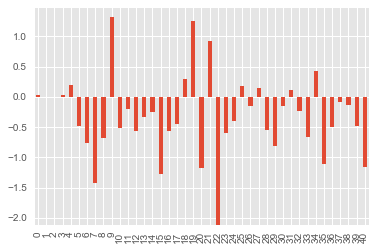

In [54]:
# now let's make a pandas Series with the names and values, and plot them
plt.style.use('ggplot')

weights = pd.Series(lr_clf.coef_[0])
weights.plot(kind='bar')
plt.show()

### SVM

In [55]:
# Run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in sss.split(X,y): 
    X_train = X[train_indices]  #train indices for X
    y_train = y[train_indices]  #train indices for y
    
    X_test = X[test_indices]    #test indices for X
    y_test = y[test_indices]    #test indices for y
    
X_train_scaled = scl_obj.transform(X_train) #apply to training
X_test_scaled = scl_obj.transform(X_test)   #apply to testing

In [58]:
# Train the model just as before
svm_clf = SVC(C=0.25, kernel='rbf', gamma='auto', random_state=True, decision_function_shape='ovr') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.844815231856
[[7038  393]
 [1123 1215]]


In [59]:
# Support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(14456L, 41L)
(14456L,)
[7437 7019]


Plotting Support Vectors Vs. Original data

In [60]:
# Make a dataframe of the training data
df_tested_on = df.iloc[train_indices] # indices chosen for training
# Now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:]

df_support['income_binary'] = y[svm_clf.support_] # add back in the 'income_binary' Column to the pandas dataframe
df['income_binary'] = y # add it back into original data set
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14456 entries, 35646 to 32784
Data columns (total 12 columns):
age                    14456 non-null int64
relationship           14456 non-null object
race                   14456 non-null object
sex                    14456 non-null object
capital_gain           14456 non-null int64
capital_loss           14456 non-null int64
hours_per_week         14456 non-null int64
condensed_education    14456 non-null object
continent              14456 non-null object
condensed_marital      14456 non-null object
condensed_workclass    14456 non-null object
income_binary          14456 non-null object
dtypes: int64(4), object(8)
memory usage: 1.4+ MB


C:\Users\TMccw\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


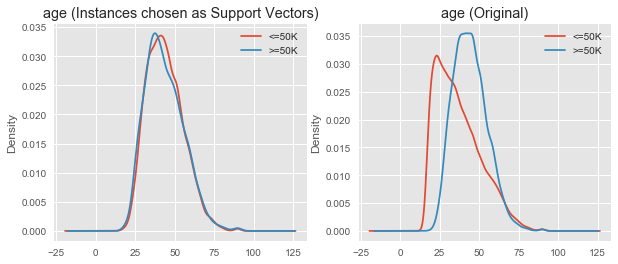

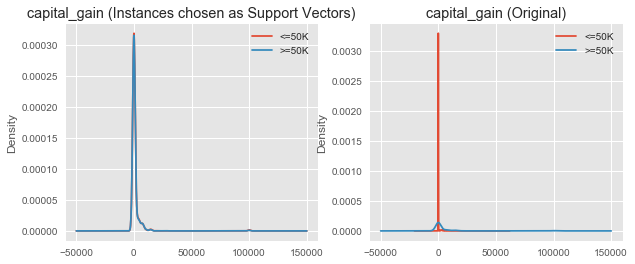

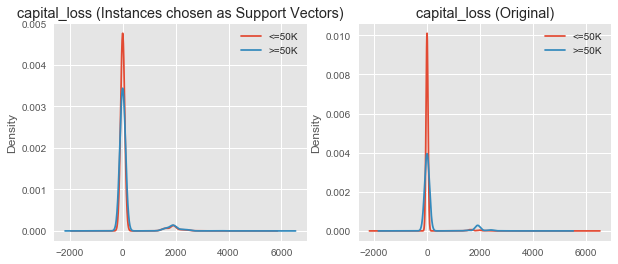

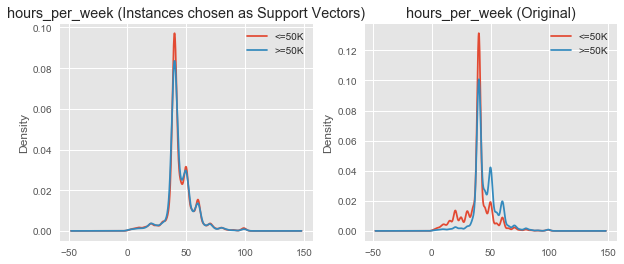

In [61]:
# Statistics of these attributes
from pandas.tools.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['income_binary'])
df_grouped = df.groupby(['income_binary'])

# plot KDE of Different variables
vars_to_plot = ['age','capital_gain','capital_loss', 'hours_per_week']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['<=50K','>=50K'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['<=50K','>=50K'])
    plt.title(v+' (Original)')